# Apartment sales ads research

Can we determine the market value of objects, having real estate ads for several previous years?
Great news: yes we can!

We have the data of the service for placing real estate ads — an archive of ads for the sale of apartments in a large Russian city and its suburbs for several years.
We need to learn how to determine the market value of real estate and set key parameters. This will allow to build an automated system: it will track anomalies and fraudulent activity.

Two types of data are available for each apartment. The first one is entered by the user, the second one is obtained automatically based on cartographic data. For example, the distance to the center, the airport, the nearest park and pond.

Let's describe our data.

* airports_nearest - distance to the nearest airport in meters (m)
* balcony - number of balconies
* ceiling_height - ceiling height (m)
* cityCenters_nearest - distance to city center (m)
* days_of_exposure - how many days the ad has been placed (from publication to removal)
* first_day_of_exposure - date of publication
* floor - floor number
* floors_total - total number of floors in the building
* is_apartment - apartment (Boolean type)
* kitchen_area_room - kitchen area in sq.m.
* last_price - price at the moment of removal from publication
* living_area - living space in square meters (m²)
* locality_name - name of the locality
* open_plan - free layout (Boolean type)
* parks_around3000 - number of parks within a radius of 3 km
* parks_nearest - distance to the nearest park (m)
* ponds_nearest3000 - number of ponds within a radius of 3 km
* ponds_nearest - distance to the nearest pond (m)
* rooms - number of rooms
* studio - one-room apartment (Boolean type)
* total_area - area of the apartment in square meters (m²)
* total_images - number of pictures of the apartment in the ad

The main steps of our project will be:

* Examining the provided data
* Data preprocessing
* Calculations and adding results to the table
* Exploratory data analysis
* General conclusion

The project is made in **Jupyter Notebook**, Notebook server version: 6.1.4.  
**Python 3.7.8**.  
The project uses **Pandas**, **MatPlotLib** libraries and the **IPython** module.

## Examining the provided data

In [1]:
# Loading the required libraries.
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
# The table has many columns. Let's display them all.
pd.set_option('display.max_columns', None)
# Separate the columns with tabs.
data = pd.read_csv('real_estate_data.csv', sep='\t')
data.info()
display(data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Conclusion

**Examining the provided data**

After splitting the columns, the data architecture was reviewed. We have a table with 22 columns and 23699 rows. 2 columns have boolean data type (bool), 3 columns have integer data type (int64) and 17 columns have text or mixed data type (object).

**Missing values**

There are missing values in fourteen object columns:

ceiling_height  
floors_total  
living_area  
is_apartment  
kitchen_area  
balcony  
locality_name  
airports_nearest  
cityCenters_nearest  
parks_around3000  
parks_nearest  
ponds_around3000  
ponds_nearest  
days_exposition

There are int64 missing values in the floor column.

## Data preprocessing

In [2]:
# Replacing NaN-values with 0 in the balcony column.
data['balcony'] = data['balcony'].fillna(0)
# Get rid of rows with NaN-values in the locality_name column.
data = data.dropna(subset=['locality_name']) 
# The table contains apartments with ceiling heights from 10.3 to 32 m.
# Most likely the author of the ad was mistaken 10 times.
# Let's fix this with the height_correction function.
def height_correction(height):
    
    if 10.3 < height <= 32:
        return height/10
    return height

data['ceiling_height'] = data['ceiling_height'].apply(height_correction)
# Change the data type from object to datetime
# in the first_day_exposition column.
data['first_day_exposition'] = pd.to_datetime(
    data['first_day_exposition'], 
    format='%Y.%m.%d'
)
# Change the data type from float to int
# in the balcony and last_price columns.
data = data.astype({'balcony':'int', 'last_price':'int'})
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  int64         
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        14490 non-null  float64       
 6   floors_total          23565 non-null  float64       
 7   living_area           21752 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          2760 non-null   object        
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          21381 non-null  float64       
 13  balcony         

### Conclusion

**Columns with missing values replaced**

Replaced NaN-values with 0 in the balcony column.
Supposed reason for the missing values: apparently, NaN-values were formed, since the author of the ad did not indicate anything in it about the number of balconies, since there are none in the apartment.   


**Columns where missing values were not replaced**

* NaN-values were not replaced in the days_exposition column. Initially, there was a hypothesis that these ads were closed within a day from the date of publication due to the favorable location of residential buildings, and, as a result, the quick start of the transaction for the purchase and sale of an apartment. And such values were entered into the database as NaN. But later, due to the lack of objective evidence, the hypothesis had to be abandoned. It is impossible to select the correct replacement of NaN-values in this column without distorting the statistical picture.

**The alleged reason for the missing values**: perhaps the program that accumulated the data did not immediately fix the closing date of the ad. It is worth contacting colleagues to clarify this point.

* In the parks_nearest and ponds_nearest columns, NaN-values were not replaced because there are no suitable replacement values, and a value of 0 in this column can be interpreted as the closest distance of a park or pond to a house. In this case, if there is no park or pond near the house, then it is more logical to indicate not 0, but a pass (NaN). For example, if 0 is specified, then one might think that the residential building is located on the territory of the park, which will mislead the analyst (there are such houses. For example, at St. Petersburg, Institutskiy per.)

**The alleged reason for the missing values**:

1. The settlement is located outside the city of St. Petersburg. Apparently, this parameter is calculated only if the apartment is located within the city.
2. The number of ponds within a radius of 3000 km is 0.  
  
    
* In the parks_around3000 and ponds_around3000 columns, NaN-values were not replaced, since they occur either when the apartment is located outside the boundaries of St. Petersburg (but this does not mean that there are no parks and ponds near these houses), or in 61 ads where there are no geographical data at all, but the name of the settlement is the city of St. Petersburg.

**The alleged reason for the missing values**:

1. The settlement is located outside the city of St. Petersburg. Apparently, this geographical parameter is calculated only if the apartment is located within the city.
2. The reason why this parameter remained in the form of NaN in 61 ads, where the city of St. Petersburg is indicated, remains unknown.

* In the airports_nearest and cityCenters_nearest columns, it is not advisable to replace missing values, since there are no suitable values for replacement, and the value 0 is not suitable for measuring distance in such arrays of information (it is worth noting that in one line there is a value of 0 in the airports_nearest column, the author of the project believes that this error). Apparently, NaN-values are most often found in advertisements for the sale of apartments located outside the city of St. Petersburg, but nevertheless they are also found in "St. Petersburg" ads.

* The table has 49 rows that have a NaN-value in the locality_name column. 8 of them do not have any geographical data. 41 of them have indications that these ads for the sale of apartments in St. Petersburg (there is geographic data, but they are considered only for St. Petersburg). At the same time, we cannot replace these values with "St. Petersburg", since in this table some districts of St. Petersburg are singled out separately and are designated as an independent settlement (for example, Pushkin, Kolpino, Peterhof and other cities. These are all districts of St. Petersburg). Thus, we do not know exactly to which locality this 41 line should be attributed. It was decided to get rid of these lines.

* In the ceiling_height, floors_total, living_area, kitchen_area, is_apartment columns, it is impossible to correctly replace NaN-values without the risk of data corruption. Most likely, the gaps in these columns were formed because filling in these data when creating an ad was optional for some time.

**Columns with data type substitution**  

In the **last_price**, **balcony** columns, the data type was changed from `float` to `int`, since it makes no sense to store this data in real form.
The **first_day_exposition** column has its data type changed from `object` to `datetime` (no time display. It doesn't make sense in this case, since the time is 00:00:00 in all cases).

NB! Changing the data type from `float` to `int` in columns that are suitable for this, but where NaN-values are present, is not possible, since if there is at least one real value in the numeric data set of type `Series`, all other data in this ` Series` will also be of type `float`.

## Calculations and adding results to the table

In [3]:
# Calculate the price per square meter.
data['sqr_meter_price'] = (
    data['last_price'] / data['total_area']
).astype(int)
# Add the weekday, month, year columns.
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year
# Add floor categories with the floor_name fucntion.
def floor_name(row):
    floor = row['floor']
    floors_total = row['floors_total']
    
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'

# For exploratory data analysis, we will need 
# numerical floor categories:
# 0 - first floor, 1 - last floor, 2 - other floor.
def floor_category(floor_names):
    
    if floor_names == 'первый':
        return 0
    elif floor_names == 'последний':
        return 1
    return 2

In [4]:
# Apply the functions.
data['flat_floor'] = data.apply(floor_name, axis=1)
data['floor_categories'] = data['flat_floor'].apply(floor_category)
# Add a column with the distance to the city center in kilometers,
# and also calculate the unit price of an apartment for 1 kilometer.
data['cityCenters_nearest_km'] = (
    data['cityCenters_nearest'] / 1000
).round()
data['price_per_km'] = (
    data['last_price'] / data['cityCenters_nearest_km']
).round()
# Calculate the shares of living space and 
# kitchen area from the total area.
data['living_total_ratio'] = data['living_area'] / data['total_area']
data['kitchen_total_ratio'] = data['kitchen_area'] / data['total_area']
display(data)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sqr_meter_price,weekday,month,year,flat_floor,floor_categories,cityCenters_nearest_km,price_per_km,living_total_ratio,kitchen_total_ratio
0,20,13000000,108.00,2019-03-07,3,2.70,16.0,51.0,8,NaN,False,False,25.00,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370,3,3,2019,другой,2,16.0,812500.0,0.472222,0.231481
1,7,3350000,40.40,2018-12-04,1,NaN,11.0,18.6,1,NaN,False,False,11.00,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920,1,12,2018,первый,0,19.0,176316.0,0.460396,0.272277
2,10,5196000,56.00,2015-08-20,2,NaN,5.0,34.3,4,NaN,False,False,8.30,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785,3,8,2015,другой,2,14.0,371143.0,0.612500,0.148214
3,0,64900000,159.00,2015-07-24,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176,4,7,2015,другой,2,7.0,9271429.0,NaN,NaN
4,2,10000000,100.00,2018-06-19,2,3.03,14.0,32.0,13,NaN,False,False,41.00,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000,1,6,2018,другой,2,8.0,1250000.0,0.320000,0.410000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000,133.81,2017-03-21,3,3.70,5.0,73.3,3,NaN,False,False,13.83,0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN,72490,1,3,2017,другой,2,4.0,2425000.0,0.547792,0.103356
23695,14,3100000,59.00,2018-01-15,3,NaN,5.0,38.0,4,NaN,False,False,8.50,0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0,52542,0,1,2018,другой,2,NaN,NaN,0.644068,0.144068
23696,18,2500000,56.70,2018-02-11,2,NaN,3.0,29.7,1,NaN,False,False,NaN,0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44091,6,2,2018,первый,0,NaN,NaN,0.523810,NaN
23697,13,11475000,76.75,2017-03-28,2,3.00,17.0,NaN,12,NaN,False,False,23.30,2,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0,149511,1,3,2017,другой,2,10.0,1147500.0,NaN,0.303583


### Conclusion
For exploratory data analysis, the necessary calculations and adding columns to the table were carried out.
* Calculated price per square meter of apartments. We can see it in the **sqr_meter_price** column
* The columns **weekday**, **month**, **year** store the information about the day of the week, month and year of publication of the announcement.
* Added word and number categories for floors where apartments are located. This data is in the **flat_floor** and **floor_categories** columns respectively. They are useful for exploratory data analysis.
* Added columns **cityCenters_nearest_km** and **price_per_km**, which store data on the distance from the apartment to the city center in kilometers (initially, the table had a column with similar information in meters) and the unit price of the apartment for 1 kilometer to the city center respectively. They are useful for exploratory data analysis.
* Added columns **living_total_ratio** and **kitchen_total_ratio**, which store the share of living area and kitchen area from the total area. They are useful for exploratory data analysis.

## Exploratory Data Analysis

It will not be possible to automate the construction of histograms of all parameters (number of rooms, price, ceiling height, area), since for each of them it is necessary to manually adjust such parameters as the number of bins and the figure size of the histogram (to make the display clear). We construct histograms manually.

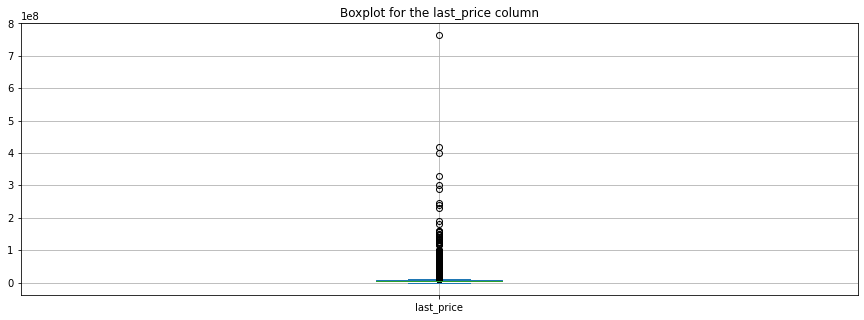

count    2.365000e+04
mean     6.541127e+06
std      1.089640e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64

4500000     342
3500000     289
4300000     260
4000000     260
4200000     258
           ... 
12890000      1
29375000      1
7545600       1
5205000       1
11475000      1
Name: last_price, Length: 2964, dtype: int64

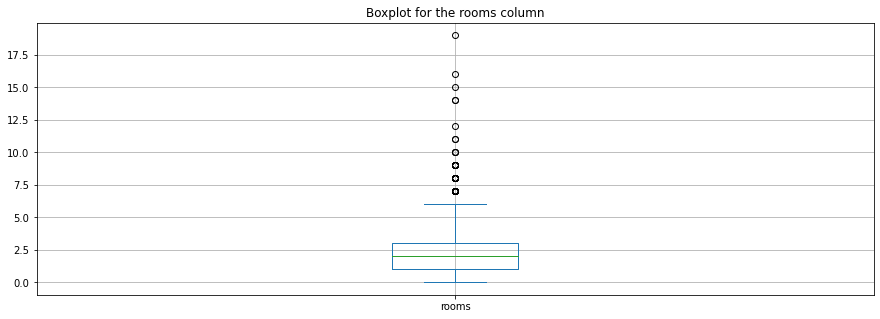

count    23650.000000
mean         2.070106
std          1.078620
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

1     8036
2     7924
3     5797
4     1175
5      326
0      197
6      105
7       59
8       12
9        8
10       3
11       2
14       2
15       1
19       1
16       1
12       1
Name: rooms, dtype: int64

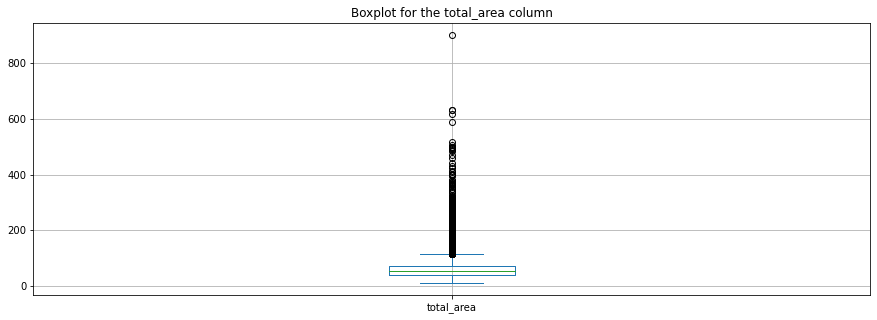

count    23650.000000
mean        60.329069
std         35.661808
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

45.00     419
42.00     383
60.00     346
31.00     346
44.00     343
         ... 
65.15       1
55.64       1
56.16       1
109.10      1
76.75       1
Name: total_area, Length: 2181, dtype: int64

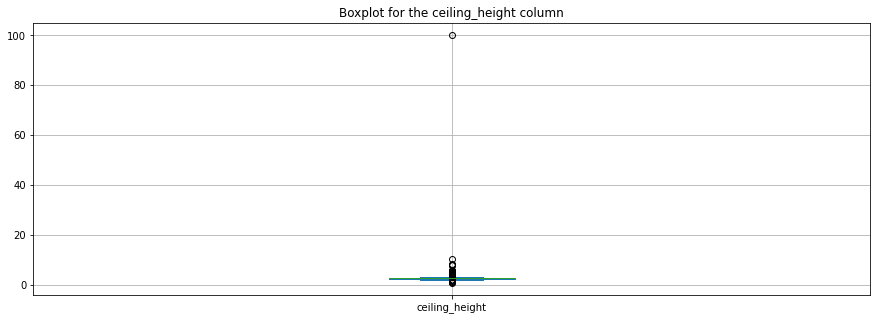

count    14490.000000
mean         2.734697
std          0.861916
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

2.50    3522
2.60    1646
2.70    1580
3.00    1109
2.80     993
        ... 
3.68       1
2.34       1
4.65       1
2.20       1
3.59       1
Name: ceiling_height, Length: 176, dtype: int64

In [5]:
# Create a function called description.
# It will help us analyze data in a fast way.
def description(table, parameter):
    
    table.plot(y=parameter, 
               kind='box', 
               grid=True, 
               figsize=(15,5)
              )
    plt.title('Boxplot for the ' + str(parameter) + ' column')
    plt.show()
    display(table[parameter].describe())
    display(table[parameter].value_counts())

parameters = ['last_price', 'rooms', 'total_area', 'ceiling_height']    
for element in parameters:
    description(data, element)

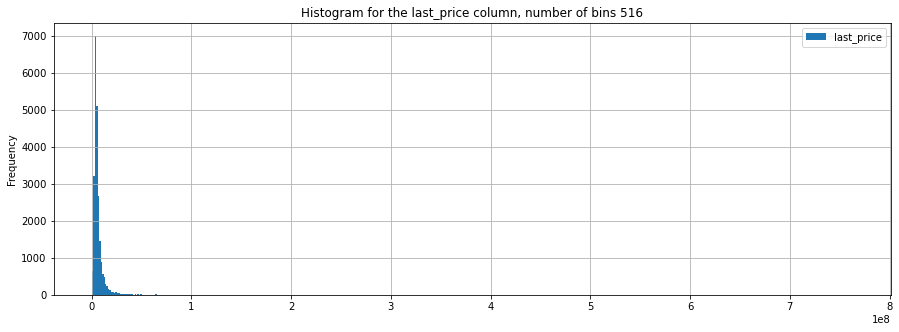

In [6]:
# Now let's build histograms for each parameter.
# Unfortunately, we deal with scaling manually.
# For a careful examination of the data,
# split histograms into regions.
# Let's start with the price.
data.plot(y='last_price', 
          kind='hist', 
          grid=True, 
          bins=516, 
          figsize=(15,5)
         )
plt.title('Histogram for the last_price column, number of bins 516')
plt.show()

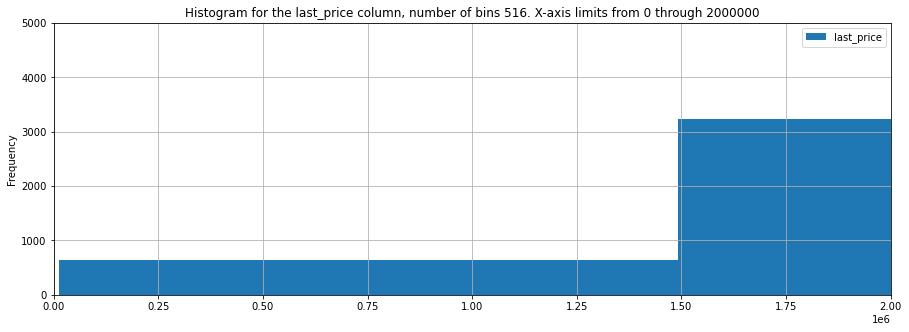

In [7]:
# Change axis limits.
data.plot(y='last_price', 
          kind='hist', 
          grid=True, 
          bins=516, 
          xlim=(0,2000000), 
          ylim=(0,5000), 
          figsize=(15,5)
         )
plt.title('Histogram for the last_price column, number of bins 516.' 
          ' X-axis limits from 0 through 2000000')
plt.show()

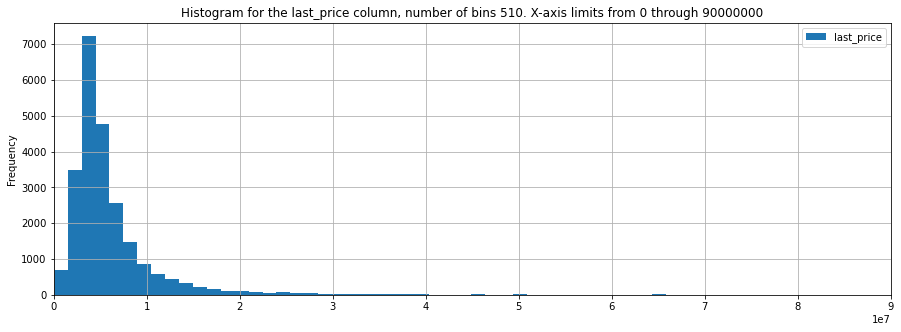

In [8]:
# Change axis limits and bins number.
data.plot(y='last_price', 
          kind='hist',
          grid=True, 
          bins=510, 
          xlim=(0,90000000), 
          figsize=(15,5)
         )
plt.title('Histogram for the last_price column, number of bins 510.' 
          ' X-axis limits from 0 through 90000000')
plt.show()

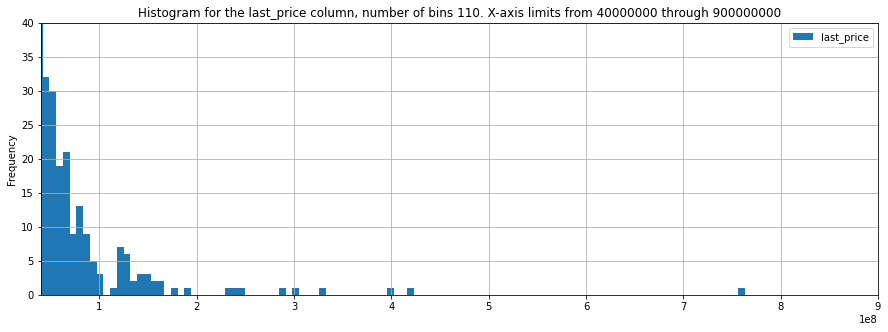

In [9]:
# Change axis limits and bins number.
data.plot(y='last_price', 
          kind='hist', 
          grid=True, 
          bins=110, 
          xlim=(40000000,900000000), 
          ylim=(0,40), 
          figsize=(15,5)
         )
plt.title('Histogram for the last_price column, number of bins 110.' 
          ' X-axis limits from 40000000 through 900000000')
plt.show()

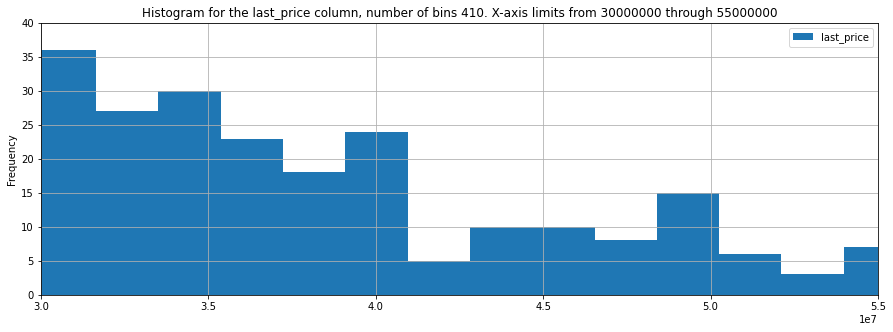

In [10]:
# Change axis limits and bins number.
data.plot(y='last_price', 
          kind='hist', 
          grid=True, 
          bins=410, 
          xlim=(30000000,55000000), 
          ylim=(0,40), 
          figsize=(15,5)
         )
plt.title('Histogram for the last_price column, number of bins 410.' 
          ' X-axis limits from 30000000 through 55000000')
plt.show()

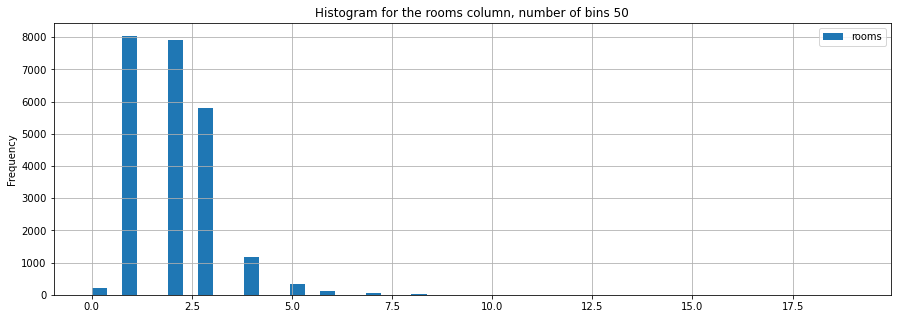

In [11]:
# Rooms number.
data.plot(y='rooms', 
          kind='hist', 
          grid=True, 
          bins=50, 
          figsize=(15,5)
         )
plt.title('Histogram for the rooms column, number of bins 50')
plt.show()

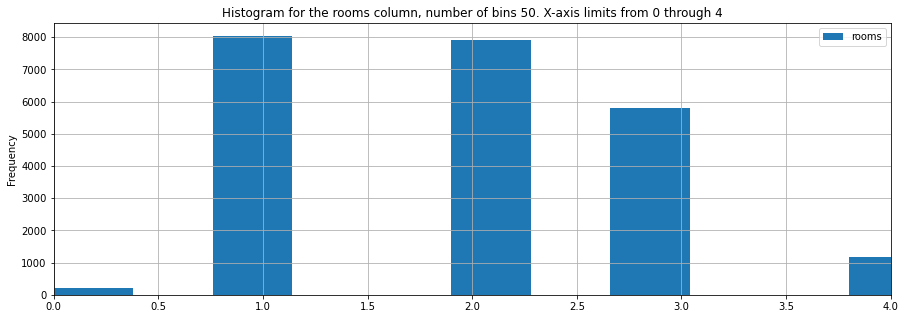

In [12]:
# Change axis limits and bins number.
data.plot(y='rooms', 
          kind='hist', 
          grid=True, 
          bins=50, 
          xlim=(0,4), 
          figsize=(15,5)
         )
plt.title('Histogram for the rooms column, number of bins 50.' 
          ' X-axis limits from 0 through 4')
plt.show()

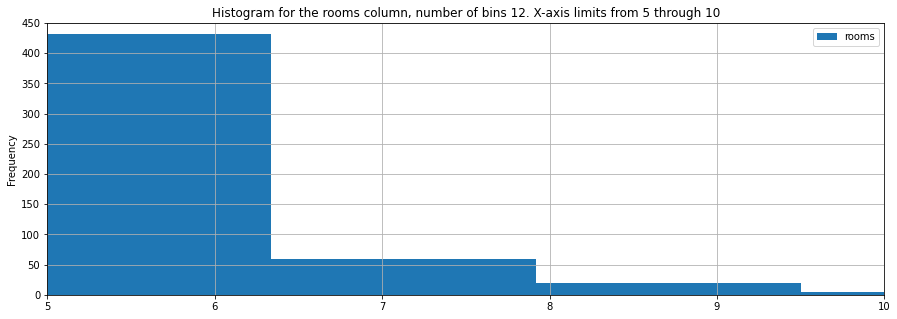

In [13]:
# Change axis limits and bins number.
data.plot(y='rooms', 
          kind='hist', 
          grid=True, 
          bins=12, 
          xlim=(5,10), 
          ylim=(0,450), 
          figsize=(15,5)
         )
plt.title('Histogram for the rooms column, number of bins 12.' 
          ' X-axis limits from 5 through 10')
plt.show()

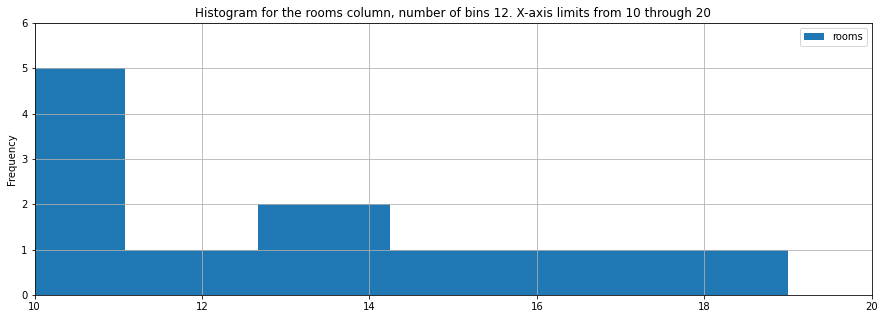

In [14]:
# Change axis limits and bins number.
data.plot(y='rooms', 
          kind='hist', 
          grid=True, 
          bins=12, 
          xlim=(10,20), 
          ylim=(0,6), 
          figsize=(15,5)
         )
plt.title('Histogram for the rooms column, number of bins 12.' 
          ' X-axis limits from 10 through 20')
plt.show()

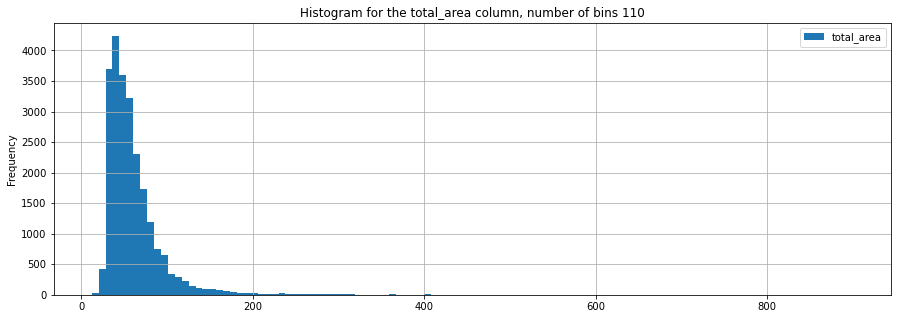

In [15]:
# Change axis limits and bins number.
data.plot(y='total_area', 
          kind='hist', 
          grid=True, 
          bins=110, 
          figsize=(15,5)
         )
plt.title('Histogram for the total_area column, number of bins 110')
plt.show()

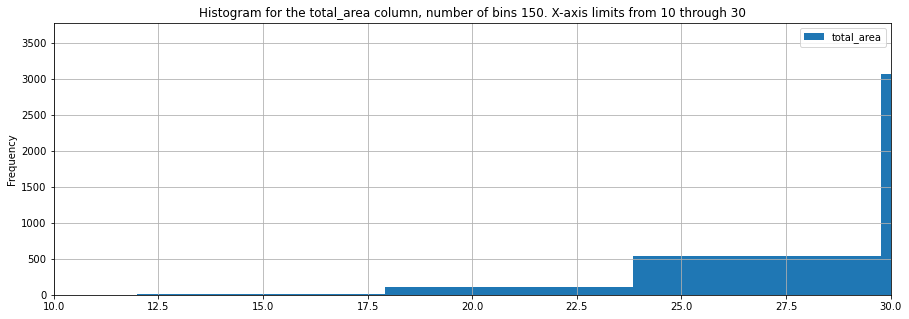

In [16]:
# Change axis limits and bins number.
data.plot(y='total_area', 
          kind='hist', 
          grid=True, 
          bins=150, 
          xlim=(10,30), 
          figsize=(15,5)
         )
plt.title('Histogram for the total_area column, number of bins 150.' 
          ' X-axis limits from 10 through 30')
plt.show()

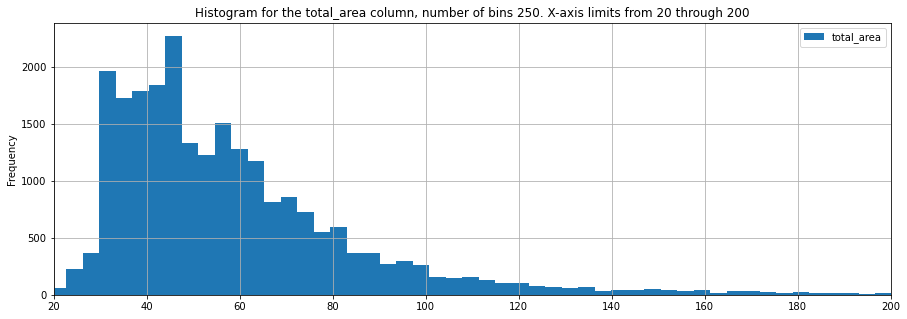

In [17]:
# Change axis limits and bins number.
data.plot(y='total_area', 
          kind='hist', 
          grid=True, 
          bins=250, 
          xlim=(20,200), 
          figsize=(15,5)
         )
plt.title('Histogram for the total_area column, number of bins 250.' 
          ' X-axis limits from 20 through 200')
plt.show()

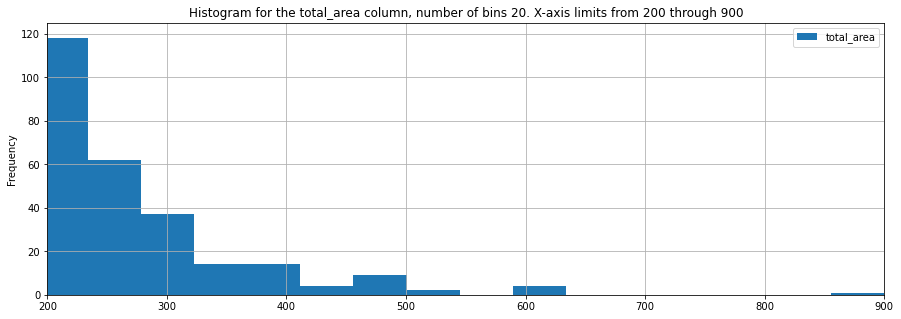

In [18]:
# Change axis limits and bins number.
data.plot(y='total_area', 
          kind='hist', 
          grid=True, 
          bins=20, 
          xlim=(200,900), 
          ylim=(0,125), 
          figsize=(15,5)
         )
plt.title('Histogram for the total_area column, number of bins 20.' 
          ' X-axis limits from 200 through 900')
plt.show()

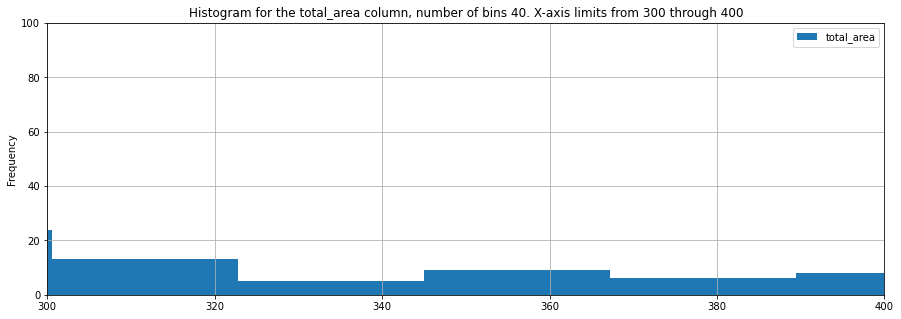

In [19]:
# Change axis limits and bins number.
data.plot(y='total_area', 
          kind='hist', 
          grid=True, 
          bins=40, 
          figsize=(15,5), 
          xlim=(300,400), 
          ylim=(0,100)
         )
plt.title('Histogram for the total_area column, number of bins 40.' 
          ' X-axis limits from 300 through 400')
plt.show()

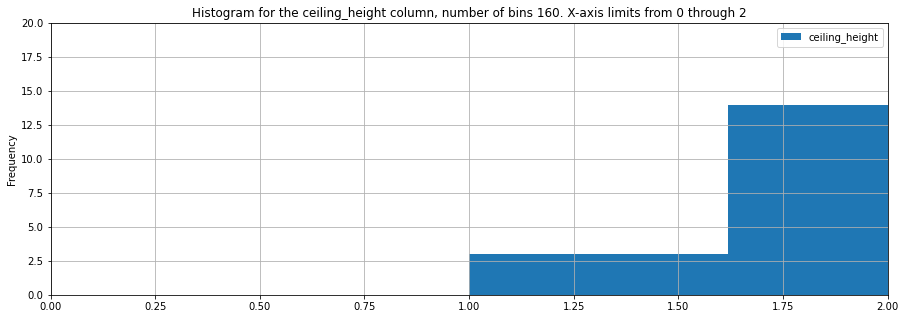

In [20]:
# Ceiling height.
data.plot(y='ceiling_height', 
          kind='hist', 
          grid=True, 
          bins=160, 
          xlim=(0,2), 
          ylim=(0,20), 
          figsize=(15,5)
         )
plt.title('Histogram for the ceiling_height column, number of bins 160.' 
          ' X-axis limits from 0 through 2')
plt.show()

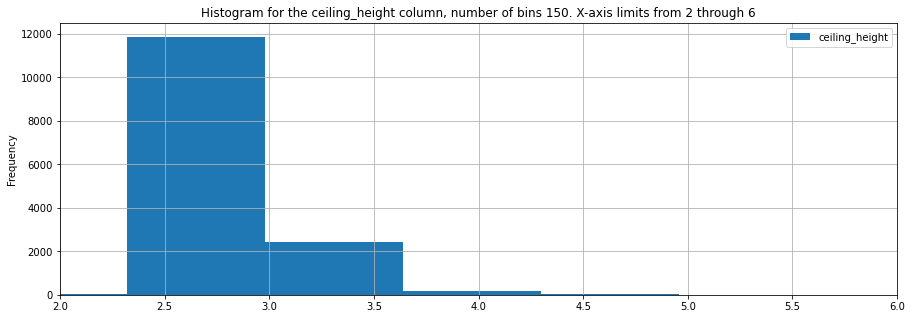

In [21]:
# Change axis limits and bins number.
data.plot(y='ceiling_height', 
          kind='hist', 
          grid=True, 
          bins=150, 
          xlim=(2,6), 
          ylim=(0,12500), 
          figsize=(15,5)
         )
plt.title('Histogram for the ceiling_height column, number of bins 150.' 
          ' X-axis limits from 2 through 6')
plt.show()

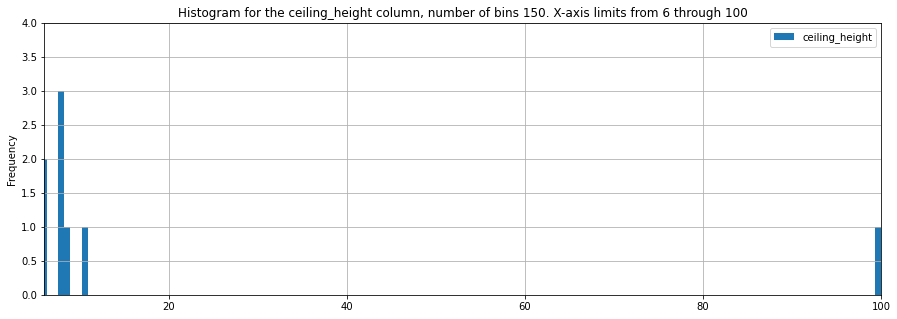

In [22]:
# Change axis limits and bins number.
data.plot(y='ceiling_height', 
          kind='hist', 
          grid=True, 
          bins=150, 
          xlim=(6,100), 
          ylim=(0,4), 
          figsize=(15,5)
         )
plt.title('Histogram for the ceiling_height column, number of bins 150.' 
          ' X-axis limits from 6 through 100')
plt.show()

**Results of the study of price, number of rooms, area and ceiling heights**  
  
**Price**  

On the <strong>average</strong>, an apartment costs <strong>6,541,127 rubles.</strong> <strong>Median</strong> value was <strong>4,650,000 rubles.</strong> <strong>Minimum</strong> price was <strong>12,190 rubles.</strong> <br><strong>Maximum </strong> &#8212; <strong>763,000,000 rubles.</strong> After evaluating the range diagram, as well as the histograms of this parameter, we can note the normal distribution of data with a shift to the left. The price is 12,190 rubles is definitely suspicious. This ad and ads similar in price qualify for exclusion from the analysis. According to the author of the project of an apartment worth more than 50,000,000 rubles and even an apartment with a maximum price of 763,000,000 rubles, it is necessary to leave it in the data, since such prices are real and reflect the reality of the residential real estate market (https://www.fontanka.ru/2020/10/11/69500383/). Perhaps at the next step of the study it will be necessary to exclude from the sample apartments more than 50,000,000 rubles, since such data are rare, and the cost of apartments from this price category is formed rather not based on the situation on the housing market, but on the subjective wishes and assessment of sellers. It is possible that for elite housing there is a separate market with its own pricing laws.  
  
**Number of rooms**  
  
The <strong>average</strong> in apartments is <strong>2.07 rooms</strong>. <strong>Median</strong> value was <strong>2 rooms.</strong> <strong>Minimum</strong> number of rooms <strong>0 rooms.</strong> <br><strong>Maximum</strong > &#8212; <strong>19 rooms.</strong> After evaluating the boxplot diagram, as well as the histograms of this parameter, we can note the normality of the distribution with a skew to the left, and also assume that there are no outliers and anomalies. A number of rooms equal to 0 means either a studio or an open plan. In the real estate market, events can occur that initially seem incredible. For example, in Moscow there is a 20-room apartment. At the next stages, it is possible to establish the upper limit of the sample in the amount of 14 rooms /).
  
**Square**  

The <strong>average</strong> area of the apartment was <strong>60.329 m<sup>2</sup></strong>. <strong>Median</strong> value was <strong>52 m<sup>2</sup>.</strong> <strong>Minimum</strong> area <strong>12 m<sup>2</sup> .</strong> <br><strong>Maximum</strong> &#8212; <strong>900 m<sup>2</sup>.</strong> After evaluating the boxplot diagram, as well as the histograms of this parameter, we can assume that the data distribution is normal with a shift to the left, and there are no outliers or anomalies. The area of an apartment of 12 m<sup>2</sup> is quite real, and the area of 900 m<sup>2</sup> can theoretically be real. Nevertheless, at the next stages, it is worth considering the exclusion from the sample of apartments with an area of more than <br>540 m<sup>2</sup> (https://lenta.ru/news/2019/08/15/spb/).
  
**Height of ceilings**  

On <strong>average</strong>, ceiling heights in apartments are <strong>2,735 m</strong>. <strong>Median</strong> value was <strong>2.65 m.</strong> <strong>Minimum</strong> ceiling height was <strong>1 m.</strong> <br><strong>Maximum </strong> &#8212; <strong>100 m.</strong> After evaluating the boxplot diagram, as well as the histograms of this parameter, we can note the presence of the second peak (from 20 to 40 m), which means that the data distribution is abnormal. Most likely, this peak was formed due to an error in fixing the bit depth of the number when entering the data. The author of the project assumes that these values are 10 times higher than in reality, and such data needs to be corrected. It is also worth noting that for data sampling it is necessary to set ceiling height limits from 2.2 m to 10 m. This will help to exclude distorted data from the study (for example, an apartment with a ceiling height of 100 m or 1 m).

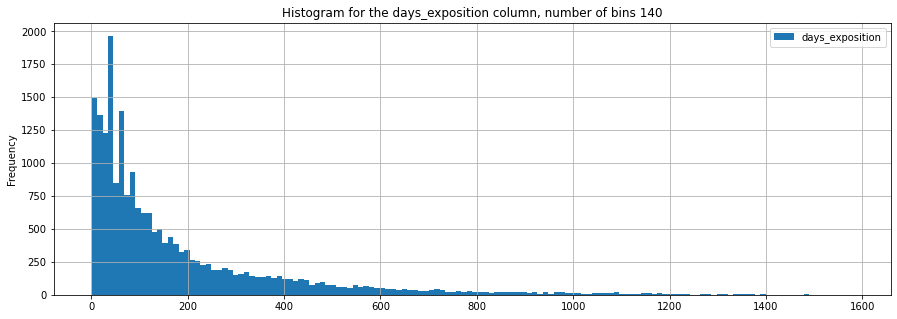

In [23]:
# It is necessary to consider in the most detailed way
# a histogram of the distribution of apartment sale time values.
# Let's build several histograms with the desired scale.
data.plot(y='days_exposition', 
          kind='hist', 
          grid=True, 
          bins=140, 
          figsize=(15,5)
         )
plt.title('Histogram for the days_exposition column, number of bins 140')
plt.show()

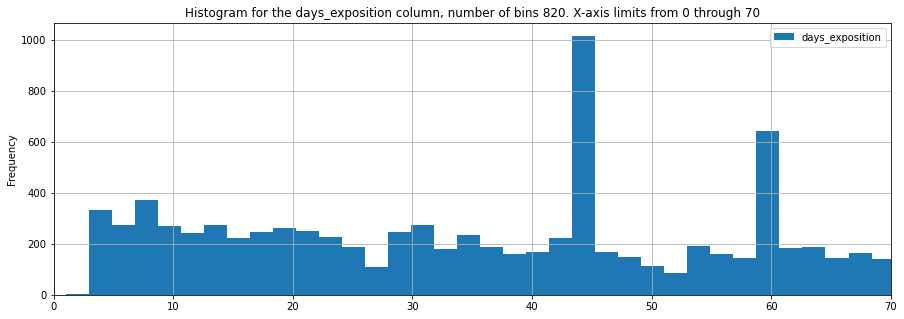

In [24]:
# Change axis limits and bins number.
data.plot(y='days_exposition', 
          kind='hist', 
          grid=True, 
          figsize=(15,5), 
          bins=820, 
          xlim=(0,70)
         )
plt.title('Histogram for the days_exposition column, number of bins 820.' 
          ' X-axis limits from 0 through 70')
plt.show()

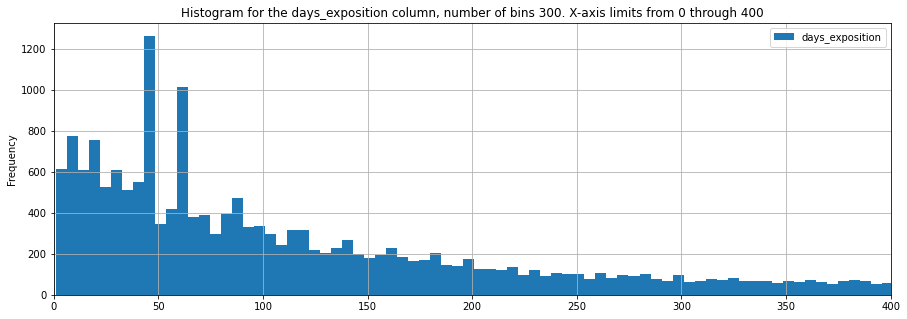

In [25]:
# Change axis limits and bins number.
data.plot(y='days_exposition', 
          kind='hist', 
          grid=True, 
          bins=300, 
          figsize=(15,5), 
          xlim=(0,400)
         )
plt.title('Histogram for the days_exposition column, number of bins 300.' 
          ' X-axis limits from 0 through 400')
plt.show()

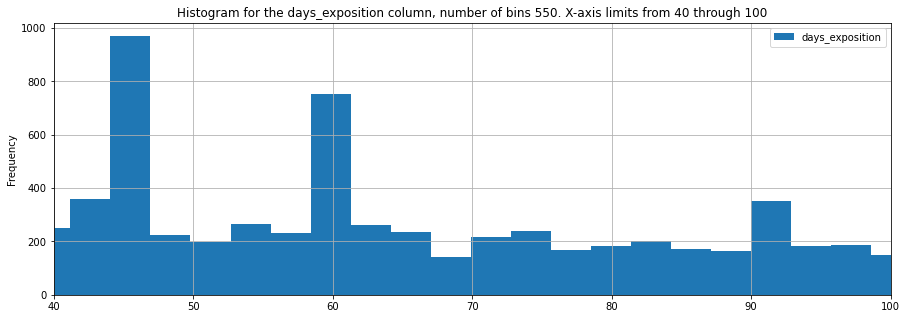

In [26]:
# Change axis limits and bins number.
data.plot(y='days_exposition', 
          kind='hist', 
          grid=True, 
          bins=550, 
          xlim=(40,100), 
          figsize=(15,5)
         )
plt.title('Histogram for the days_exposition column, number of bins 550.' 
          ' X-axis limits from 40 through 100')
plt.show()

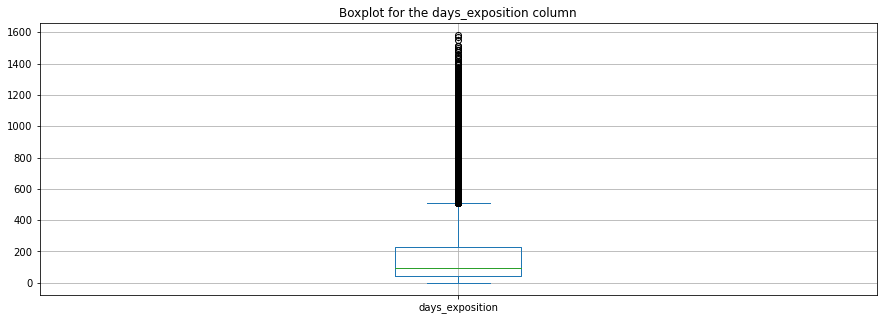

In [27]:
# Plot a boxplot.
data.plot(y='days_exposition', 
          kind='box', 
          grid=True, 
          figsize=(15,5)
         )
plt.title('Boxplot for the days_exposition column')
plt.show()

In [28]:
# Describe the data.
display(data['days_exposition'].describe())
display(data['days_exposition'].value_counts().sort_index(
    ascending=True
)
       )

count    20470.000000
mean       180.753200
std        219.777916
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

1.0         1
2.0         3
3.0       158
4.0       174
5.0       152
         ... 
1512.0      2
1513.0      1
1553.0      1
1572.0      1
1580.0      1
Name: days_exposition, Length: 1141, dtype: int64

**Apartment sale time**
The **average** time for selling an apartment is **180.75 days**. **Median** value is **95 days.** **Minimum** apartment sale time is **1 day.** **Maximum** &#8212; **1580 days.** <br>After evaluating the boxplot and the histogram, we can note the presence of two suspicious peaks (45 days, 60 days), which means that the data distribution is not normal. The histogram is more like a Poisson distribution. An analysis of the data in the area of these peaks was carried out in order to determine the patterns and reasons for their formation. Sections of announcements were made within the limits of 44.2-45.1 days and 50.8-60.1 days. The specific characteristics of these slices were compared with the remaining parts of the data set. The sections themselves were analyzed for the content of unusual patterns (for example, what if most of the ads closed after 45 and 60 days were for the sale of apartments in one locality? Or suddenly these apartments have similar characteristics?). In the course of the analysis, no patterns were identified, according to which there was an increase in the frequency of closing ads in these periods. <br>Despite the fact that these peaks (45 and 60 days) make the distribution abnormal, the author of the project has no reason to process them, discard them, exclude from the analysis, since there is no reason to consider them anomalies, as well as similar behavior of buyers quite real and may be due to unknown factors. There is also the possibility that these histogram bars have formed as peaks due to the presence of NaN-values, when in fact they are noise.<br>Currently, sales are typically completed in 95 days. A sale in 1 day is considered very fast. It's possible. Despite the fact that the transaction is unlikely to be completed in 1 day, the seller may well remove the ad from the service if the potential buyer transfers the deposit to him. None of the presented sales can be called unusually long sales. Almost any term for the sale of an apartment is real. The maximum value is 1580 days, and such a value (about 4 years) is quite realistic.

In [29]:
# Get rid of rare values and single-valued outliers.
# To begin with, we will cut off all data with a price 
# above 50,000,000 rubles.
# Exclude the line with the price of the apartment 12,190 rubles.
# Cut apartments with an area of more than 320 square meters. m.,
# apartments with more than 8 rooms,
# apartments in buildings with more than 37 floors.
data_good_floors = data.loc[
    (data['last_price'] <= 50_000_000) &
    (data['last_price'] != 12190) &
    (data['total_area'] < 320) &
    (data['rooms'] <= 8) &
    (data['floors_total'] <= 37)
]

In [30]:
# Cut apartments with unlikely ceiling heights.
data_final = data_good_floors.query(
    '(ceiling_height >= 2) and (ceiling_height != 100)'
    'or (ceiling_height != ceiling_height)'
)
display(data_final)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sqr_meter_price,weekday,month,year,flat_floor,floor_categories,cityCenters_nearest_km,price_per_km,living_total_ratio,kitchen_total_ratio
0,20,13000000,108.00,2019-03-07,3,2.70,16.0,51.0,8,NaN,False,False,25.00,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370,3,3,2019,другой,2,16.0,812500.0,0.472222,0.231481
1,7,3350000,40.40,2018-12-04,1,NaN,11.0,18.6,1,NaN,False,False,11.00,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920,1,12,2018,первый,0,19.0,176316.0,0.460396,0.272277
2,10,5196000,56.00,2015-08-20,2,NaN,5.0,34.3,4,NaN,False,False,8.30,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785,3,8,2015,другой,2,14.0,371143.0,0.612500,0.148214
4,2,10000000,100.00,2018-06-19,2,3.03,14.0,32.0,13,NaN,False,False,41.00,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000,1,6,2018,другой,2,8.0,1250000.0,0.320000,0.410000
5,10,2890000,30.40,2018-09-10,1,NaN,12.0,14.4,5,NaN,False,False,9.10,0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,95065,0,9,2018,другой,2,NaN,NaN,0.473684,0.299342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000,133.81,2017-03-21,3,3.70,5.0,73.3,3,NaN,False,False,13.83,0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN,72490,1,3,2017,другой,2,4.0,2425000.0,0.547792,0.103356
23695,14,3100000,59.00,2018-01-15,3,NaN,5.0,38.0,4,NaN,False,False,8.50,0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0,52542,0,1,2018,другой,2,NaN,NaN,0.644068,0.144068
23696,18,2500000,56.70,2018-02-11,2,NaN,3.0,29.7,1,NaN,False,False,NaN,0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44091,6,2,2018,первый,0,NaN,NaN,0.523810,NaN
23697,13,11475000,76.75,2017-03-28,2,3.00,17.0,NaN,12,NaN,False,False,23.30,2,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0,149511,1,3,2017,другой,2,10.0,1147500.0,NaN,0.303583


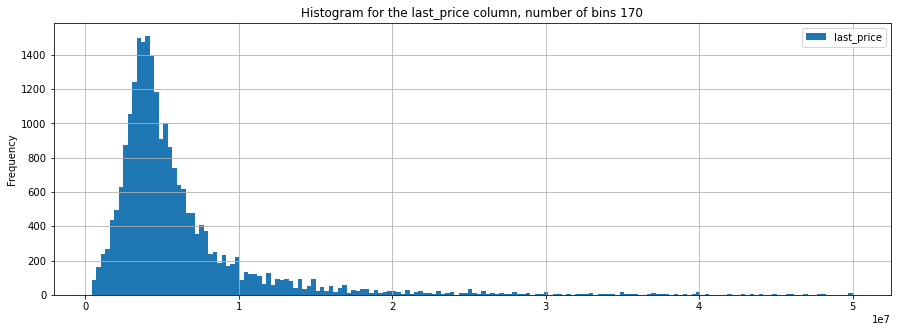

In [31]:
# Let's analyze the resulting data sample.
data_final.plot(
    y='last_price', 
    kind='hist', 
    grid=True, 
    bins=170, 
    figsize=(15,5)
)
plt.title('Histogram for the last_price column, number of bins 170')
plt.show()

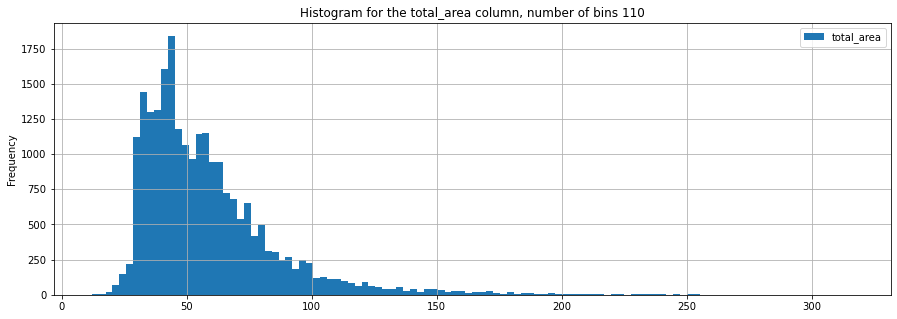

In [32]:
data_final.plot(
    y='total_area', 
    kind='hist', 
    grid=True, 
    bins=110, 
    figsize=(15,5)
)
plt.title('Histogram for the total_area column, number of bins 110')
plt.show()

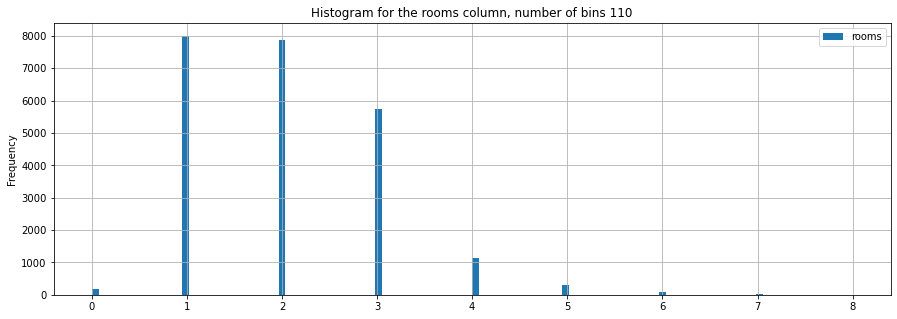

In [33]:
data_final.plot(
    y='rooms', 
    kind='hist', 
    grid=True, 
    bins=110, 
    figsize=(15,5)
)
plt.title('Histogram for the rooms column, number of bins 110')
plt.show()

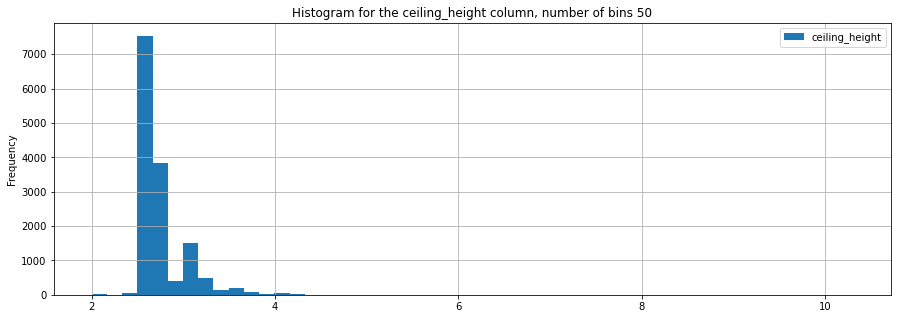

In [34]:
data_final.plot(
    y='ceiling_height', 
    kind='hist', 
    grid=True, 
    bins=50, 
    figsize=(15,5)
)
plt.title('Histogram for the ceiling_height column, number of bins 50')
plt.show()

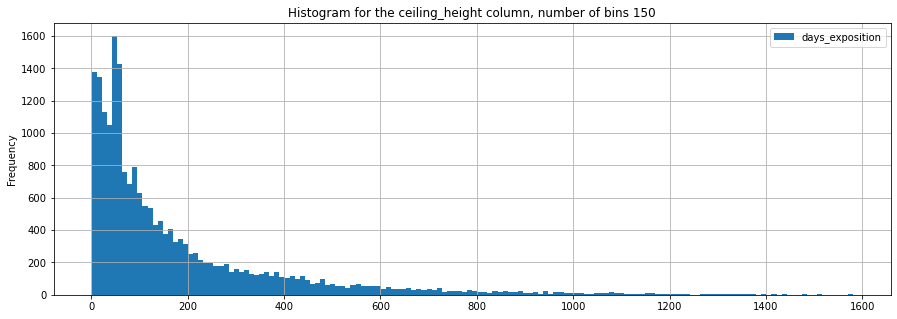

In [35]:
data_final.plot(
    y='days_exposition', 
    kind='hist', 
    grid=True, 
    bins=150, 
    figsize=(15,5)
)
plt.title('Histogram for the ceiling_height column, number of bins 150')
plt.show()

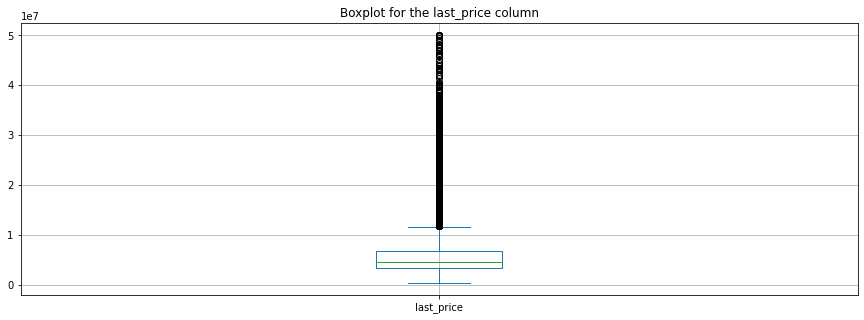

count    2.339100e+04
mean     5.958070e+06
std      4.870064e+06
min      4.300000e+05
25%      3.400000e+06
50%      4.600000e+06
75%      6.700000e+06
max      5.000000e+07
Name: last_price, dtype: float64

4500000     341
3500000     289
4300000     260
4000000     260
4200000     258
           ... 
12890000      1
29375000      1
7545600       1
42000000      1
11475000      1
Name: last_price, Length: 2810, dtype: int64

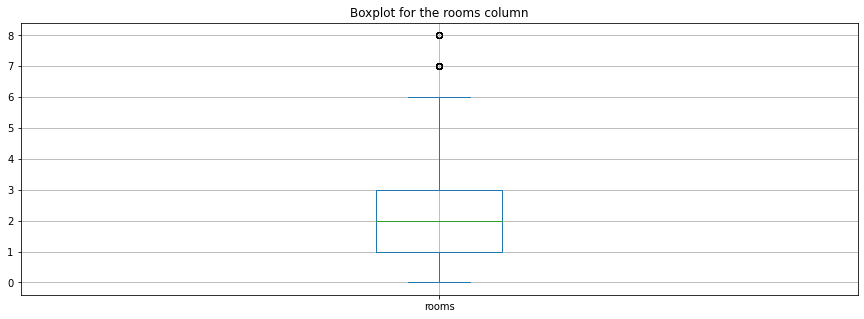

count    23391.000000
mean         2.047283
std          1.019513
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: rooms, dtype: float64

1    8000
2    7887
3    5746
4    1138
5     294
0     193
6      85
7      40
8       8
Name: rooms, dtype: int64

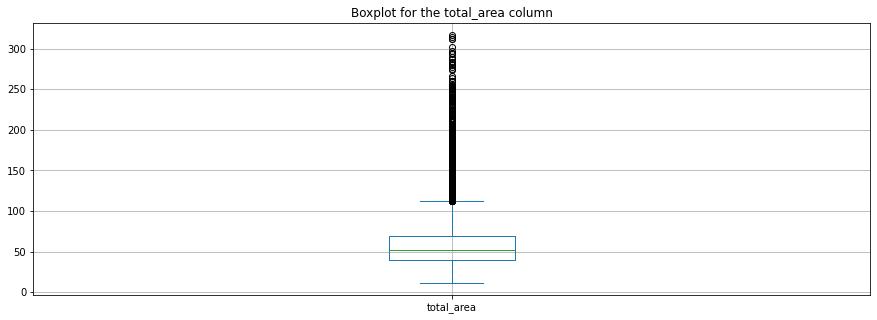

count    23391.000000
mean        58.781417
std         28.856020
min         12.000000
25%         40.000000
50%         52.000000
75%         69.000000
max        316.300000
Name: total_area, dtype: float64

45.00     419
42.00     383
31.00     346
60.00     346
44.00     343
         ... 
58.71       1
60.75       1
63.19       1
237.00      1
76.75       1
Name: total_area, Length: 2064, dtype: int64

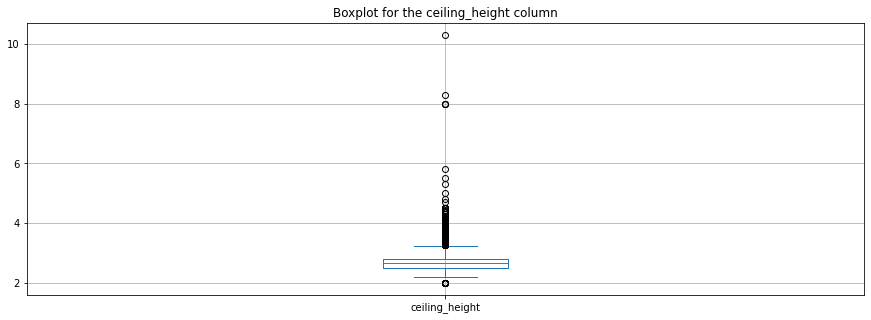

count    14362.000000
mean         2.722782
std          0.288865
min          2.000000
25%          2.500000
50%          2.650000
75%          2.800000
max         10.300000
Name: ceiling_height, dtype: float64

2.50    3521
2.60    1646
2.70    1578
3.00    1088
2.80     987
        ... 
3.44       1
2.34       1
5.30       1
2.20       1
3.59       1
Name: ceiling_height, Length: 163, dtype: int64

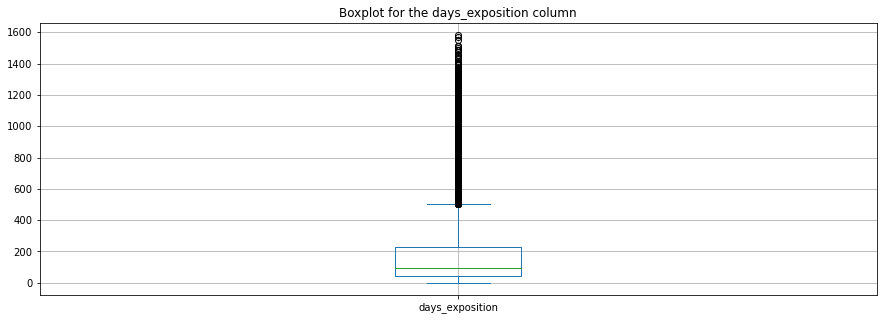

count    20258.000000
mean       179.897028
std        219.006659
min          1.000000
25%         45.000000
50%         95.000000
75%        229.000000
max       1580.000000
Name: days_exposition, dtype: float64

45.0      877
60.0      538
7.0       234
30.0      208
90.0      195
         ... 
1105.0      1
795.0       1
1089.0      1
822.0       1
971.0       1
Name: days_exposition, Length: 1136, dtype: int64

In [36]:
parameters = ['last_price', 'rooms', 'total_area', 'ceiling_height', 'days_exposition']    
for element in parameters:
    description(data_final, element)

**Data slices created. Removed rare and outlier values**
* We got rid of apartments more expensive than 50,000,000 rubles.
* We got rid of apartments with an area of more than 320 m<sup>2</sup> and with more than 8 rooms
* We got rid of houses with more than 37 floors (this is exactly the number of floors in the tallest residential building in St. Petersburg)
* Get rid of apartments with unlikely ceiling heights

After creating the slices, the histograms are not as sweeping as they were originally. Their shape has become more similar to normal, while the slopes are preserved. The histogram for the **days_exposition** column still has 2 peaks.

,last_price,total_area,rooms,floor_categories,cityCenters_nearest
last_price,1.000000,0.782844,0.492378,0.128397,-0.292011
total_area,0.782844,1.000000,0.764652,0.100012,-0.183782
rooms,0.492378,0.764652,1.000000,0.025107,-0.163681
floor_categories,0.128397,0.100012,0.025107,1.000000,-0.048787
cityCenters_nearest,-0.292011,-0.183782,-0.163681,-0.048787,1.000000


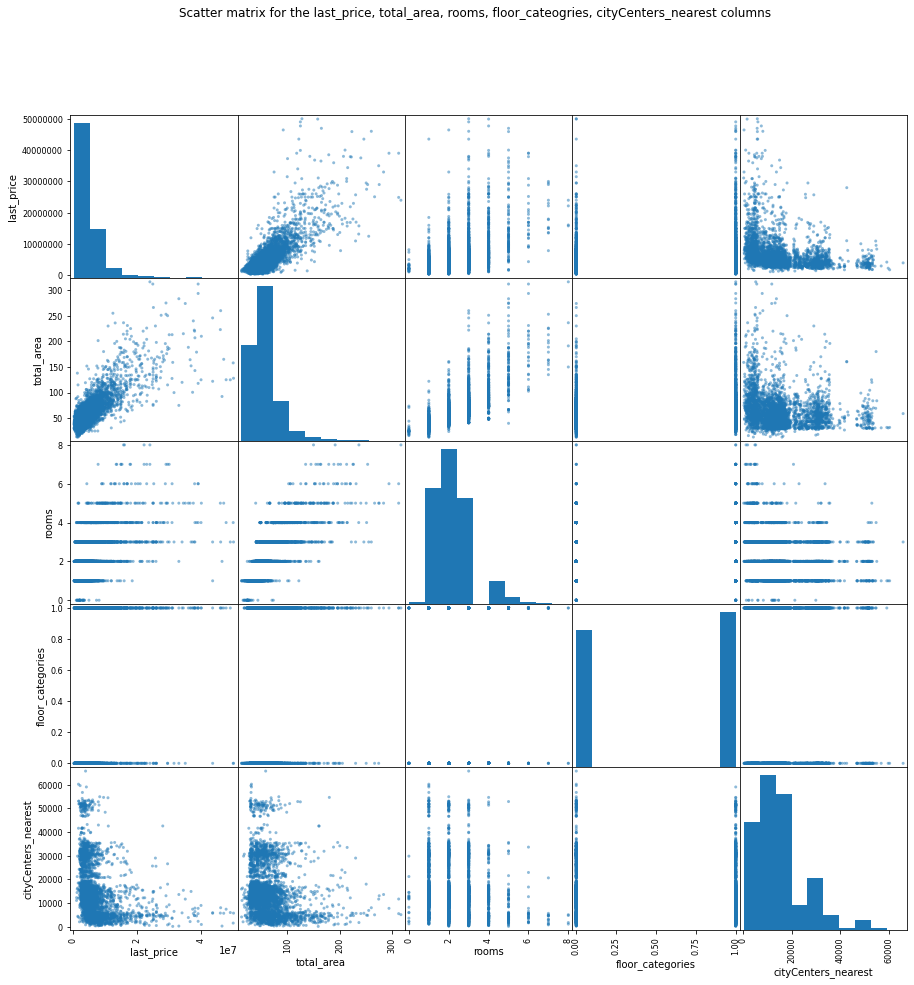

In [37]:
# Determine the dependence of the price of an apartment on the area, 
# quantity of rooms, floor (first or last) and distance to city center.
# Create a column slice for analysis.
data_corr1 = data_final[['last_price',
                         'total_area', 
                         'rooms', 
                         'floor_categories', 
                         'cityCenters_nearest']]
# Exclude apartments located on "other" floors.
data_corr1_final = data_corr1.query('floor_categories != 2')
# Construct the scatter matrix, and also
# calculate Pearson's correlation coefficients.
pd.plotting.scatter_matrix(data_corr1_final, figsize=(15,15))
plt.suptitle('Scatter matrix for the last_price,' 
             ' total_area, rooms, floor_cateogries, cityCenters_nearest columns')
display(data_corr1_final.corr())

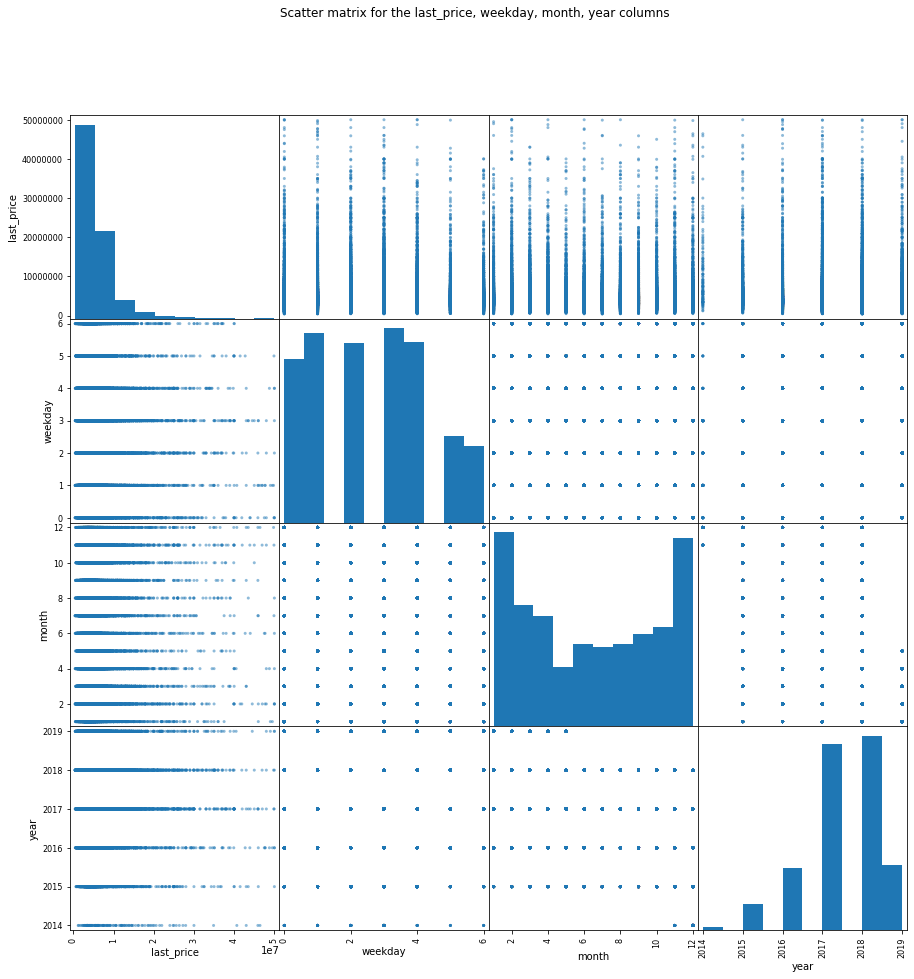

,last_price,weekday,month,year
last_price,1.000000,-0.017111,0.004410,-0.045723
weekday,-0.017111,1.000000,0.012867,-0.002930
month,0.004410,0.012867,1.000000,-0.271863
year,-0.045723,-0.002930,-0.271863,1.000000


In [38]:
# Let's analyze the influence of the day of the week, month and 
# year of placing an ad on the price.
data_corr2 = data_final[['last_price','weekday','month','year']]
pd.plotting.scatter_matrix(data_corr2, figsize=(15,15))
plt.suptitle('Scatter matrix for the ' +
             'last_price, weekday, month, year columns')
plt.show()
display(data_corr2.corr())

**Analysis of the influence of factors on the price of an apartment**  
An analysis of the scatter matrix, as well as Pearson's correlation coefficients, showed:
* There is a fairly strong direct dependence of the price of an apartment on its area.
* There is a direct relationship between the price of an apartment and the number of rooms. However, it is not very strong.
* There is a very slight direct relationship between the price of an apartment and its floor.
* There is an inverse relationship between the price of an apartment and its distance to the center. However, it is insignificant.
* There is practically no relationship between the price of an apartment and the date the ad was placed (be it a day, a month or a year).

**Conclusion:** The determining factor in the formation of the price of an apartment is to a greater extent its area. Also, pricing can be affected by the number of rooms and the distance to the city center. To a small extent, the price of an apartment can be affected by the floor on which it is located.

In [39]:
# Calculate the average price per square meter of housing.
mean_price = data_final.pivot_table(index='locality_name',
                                    values='sqr_meter_price',
                                    aggfunc=['mean','count'])
# Rename the "two-lines" column names.
mean_price.columns = ['mean_sqr_meter_price', 'number']
# Trim the resulting table by row.
# Let's leave the 10 most common settlements.
mean_price = mean_price.sort_values(
    by='number', ascending=False).reset_index().truncate(after=9)
# For the convenience of displaying the result, we pass
# row indexes column names locality_name.
mean_price = mean_price.set_index('locality_name')
display(mean_price)
print('Among the 10 most mentioned cities, the highest average ' + 
      'cost of housing in the city ' + 
      '{}. \nIt is {:.0f} rubles/sq.m.'.format(
          mean_price['mean_sqr_meter_price'].idxmax(), 
          mean_price['mean_sqr_meter_price'].max()
      )
     )
print('Among the 10 most mentioned cities, the lowest average '+
      'cost of housing in the city ' +
      '{}. \nIt is {:.0f} rubles/sq.m.'.format(
          mean_price['mean_sqr_meter_price'].idxmin(), 
          mean_price['mean_sqr_meter_price'].min()
      )
     )

,mean_sqr_meter_price,number
locality_name,,
Санкт-Петербург,112264.468256,15483
посёлок Мурино,85672.803846,520
посёлок Шушары,78550.883827,439
Всеволожск,68654.007538,398
Пушкин,103130.405995,367
Колпино,75332.866469,337
посёлок Парголово,90175.489297,327
Гатчина,68745.693811,307
деревня Кудрово,92473.086957,299


Among the 10 most mentioned cities, the highest average cost of housing in the city Санкт-Петербург. 
It is 112264 rubles/sq.m.
Among the 10 most mentioned cities, the lowest average cost of housing in the city Выборг. 
It is 58141 rubles/sq.m.


**Ranking settlements by frequency of mention**  
A rating of the 10 most mentioned settlements in the sample has been created. The most frequently mentioned ads for the sale of apartments in St. Petersburg. Least of all &ndash; in Vyborg. The same settlements rank first and tenth in terms of the average price per square meter of housing: 112,264 rubles/m<sup>2</sup> and 58,141 rubles/m<sup>2</sup>, respectively.

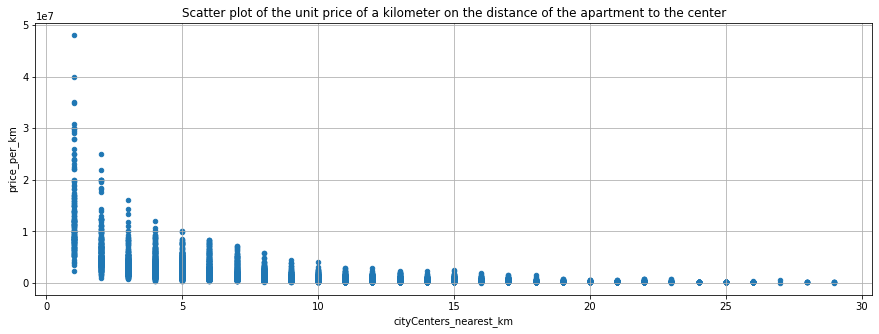

In [40]:
# Let's leave only ads in St. Petersburg.
spb_data = data_final.query('locality_name == "Санкт-Петербург"')
# Define the border of the conditional center. 
# Let's build a dependency graph unit price per kilometer 
# from the distance of the apartment to the center.
spb_data.sort_values(
    'cityCenters_nearest_km').plot(
    x='cityCenters_nearest_km', 
    y='price_per_km',
    kind='scatter', 
    grid=True, 
    figsize=(15,5)
)
plt.title('Scatter plot of the unit price of a kilometer' +
          ' on the distance of the apartment to the center')
plt.show()

**Conclusion:**
From the graph, you can see how the unit price increases, starting from a distance of 10 km. But it begins to show a significant, sharp increase from 4 km. This will be the boundary of the center. Using, for example, the Yandex.Maps "ruler" tool, you can make sure that this border is selected correctly.

The average price per square meter of housing in the center of St. Petersburg is 133293 rubles/sq. m


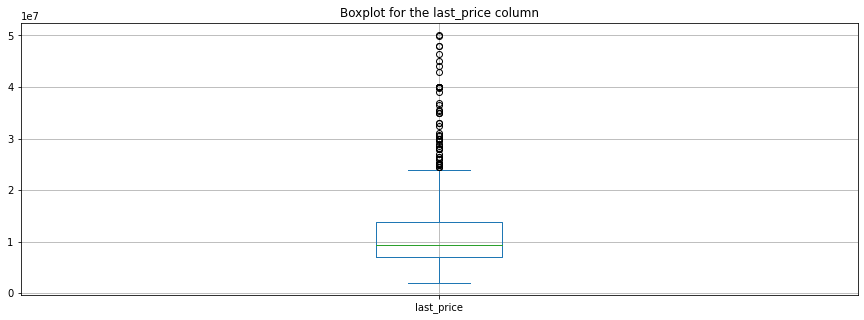

count    8.310000e+02
mean     1.176332e+07
std      7.515985e+06
min      2.100000e+06
25%      7.125000e+06
50%      9.400000e+06
75%      1.392500e+07
max      5.000000e+07
Name: last_price, dtype: float64

8000000     18
9000000     16
12000000    13
9500000     12
10000000    11
            ..
10700000     1
18850000     1
5880000      1
39900000     1
15350000     1
Name: last_price, Length: 357, dtype: int64

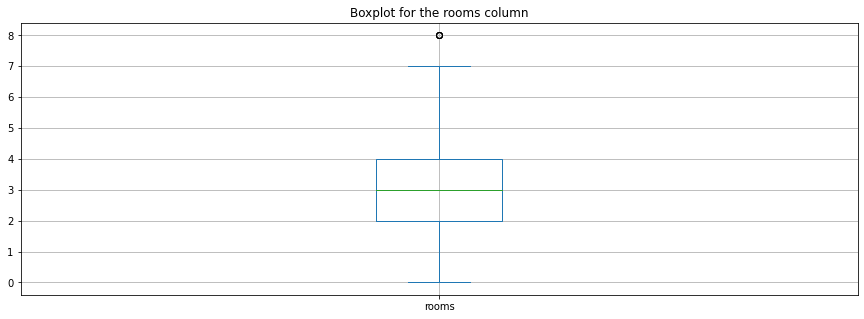

count    831.000000
mean       3.008424
std        1.342961
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        8.000000
Name: rooms, dtype: float64

3    261
2    253
4    138
1     70
5     62
6     26
7     13
8      4
0      4
Name: rooms, dtype: int64

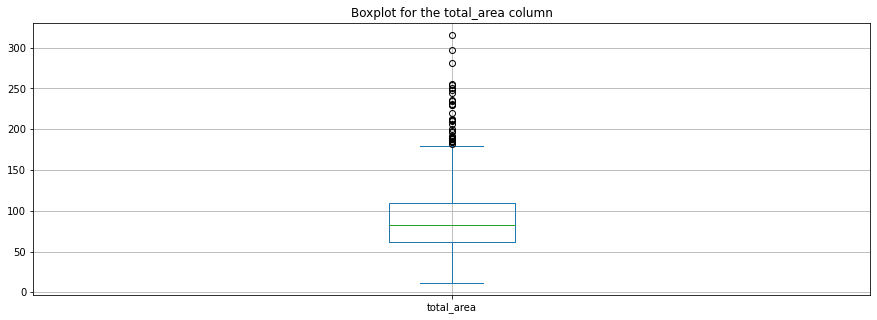

count    831.000000
mean      91.017714
std       42.702510
min       12.000000
25%       62.100000
50%       82.100000
75%      110.000000
max      315.000000
Name: total_area, dtype: float64

50.0     17
60.0     12
70.0     12
80.0     10
96.0     10
         ..
87.5      1
105.1     1
68.6      1
122.2     1
158.5     1
Name: total_area, Length: 447, dtype: int64

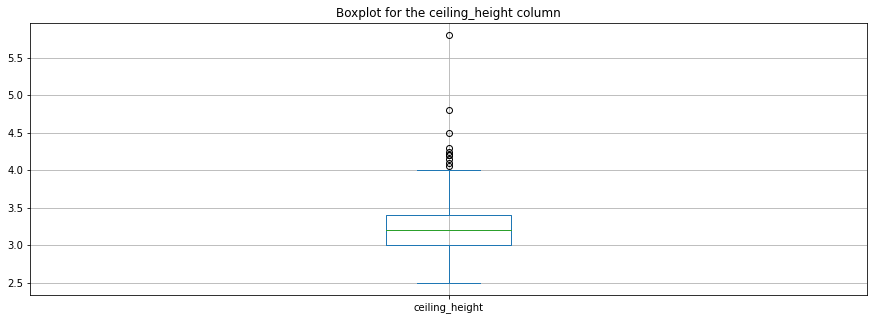

count    580.000000
mean       3.202586
std        0.374574
min        2.500000
25%        3.000000
50%        3.200000
75%        3.400000
max        5.800000
Name: ceiling_height, dtype: float64

3.00    80
3.20    53
3.50    45
3.10    31
3.30    30
        ..
2.86     1
3.84     1
2.77     1
4.30     1
3.14     1
Name: ceiling_height, Length: 98, dtype: int64

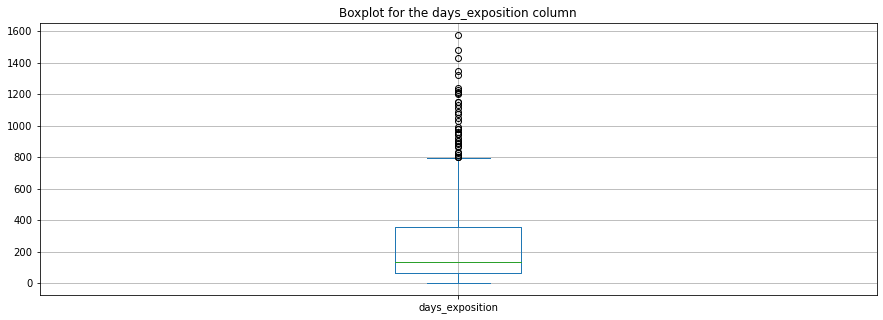

count     681.000000
mean      249.035242
std       276.321640
min         3.000000
25%        61.000000
50%       134.000000
75%       353.000000
max      1572.000000
Name: days_exposition, dtype: float64

90.0     26
60.0     16
30.0     11
4.0       6
19.0      6
         ..
715.0     1
93.0      1
445.0     1
137.0     1
621.0     1
Name: days_exposition, Length: 376, dtype: int64

In [41]:
# Leave only apartments located in the conditional center.
spb_data_center = spb_data.query('cityCenters_nearest_km < 4')
print('The average price per square meter of housing in the center of St. Petersburg is ' +
      '{:.0f} rubles/sq. m'.format(round(spb_data_center['sqr_meter_price'].mean())))
# Let's use the description function again 
# to statistically describe the parameters.
for element in parameters:
    description(spb_data_center, element)

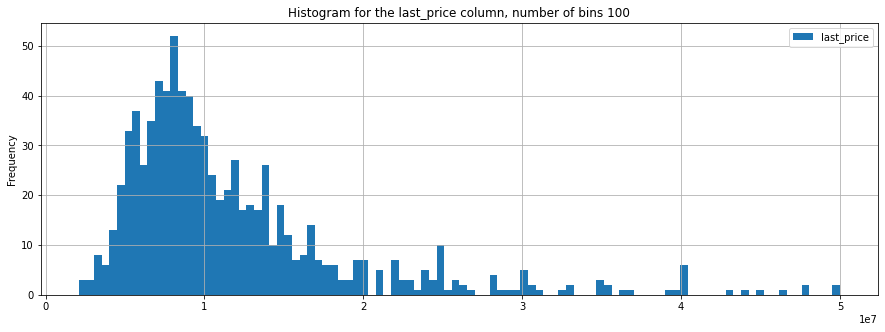

In [42]:
# Now let's build histograms for each parameter.
# We select the number of bins manually.
# Let's start with the price.
spb_data_center.plot(y='last_price', 
                     kind='hist', 
                     grid=True, 
                     bins=100, 
                     figsize=(15,5)
                    )
plt.title('Histogram for the last_price column, number of bins 100')
plt.show()

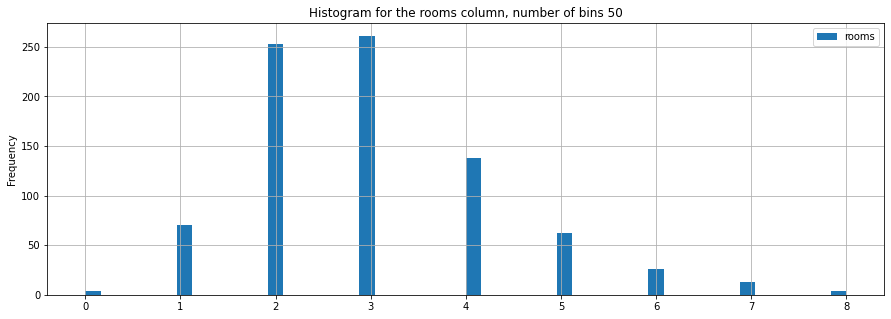

In [43]:
# Rooms number.
spb_data_center.plot(y='rooms', 
                     kind='hist', 
                     grid=True, 
                     bins=50, 
                     figsize=(15,5)
                    )
plt.title('Histogram for the rooms column, number of bins 50')
plt.show()

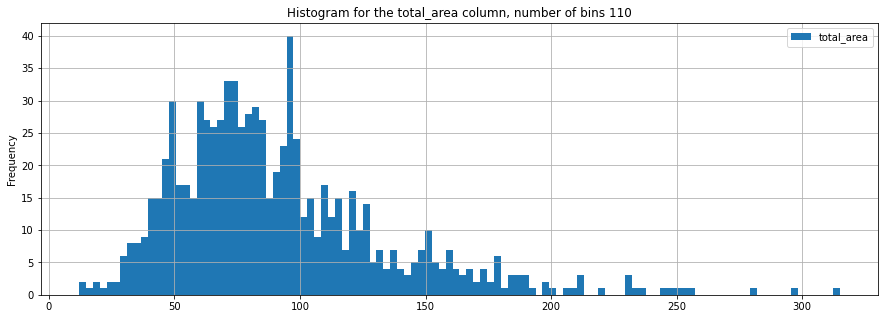

In [44]:
# Total area.
spb_data_center.plot(y='total_area', 
                     kind='hist', 
                     grid=True, 
                     bins=110, 
                     figsize=(15,5))
plt.title('Histogram for the total_area column, number of bins 110')
plt.show()

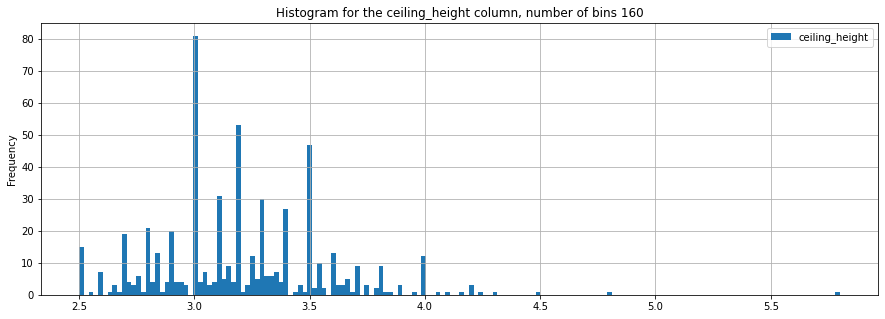

In [45]:
# Ceiling height.
spb_data_center.plot(y='ceiling_height', 
                     kind='hist', 
                     grid=True, 
                     bins=160, 
                     figsize=(15,5))
plt.title('Histogram for the ceiling_height column, number of bins 160')
plt.show()

**Results of studying the price, number of rooms, area and ceiling height in apartments in the central part of St. Petersburg**
  
**Price**  

On the <strong>average</strong>, an apartment costs <strong>11,763,320 rubles</strong>. <strong>Median</strong> value was <strong>9,400,000 rubles.</strong> <strong>Minimum</strong> price was <strong>2,100,000 rubles.</strong> <br><strong> Maximum</strong> &#8212; <strong>50,000,000 rubles.</strong> After evaluating the boxplot, as well as the histograms of this parameter, we can note the normal distribution of data with a skew to the left.  
  
**Number of rooms**  
    
In <strong>average</strong> in apartments <strong>3 rooms</strong>. <strong>Median</strong> value was <strong>3 rooms.</strong> <strong>Minimum</strong> number of rooms <strong>0 rooms.</strong> <br><strong>Maximum</strong > &#8212; <strong>8 rooms.</strong> After evaluating the boxplot, as well as the histograms of this parameter, we can note the normality of the distribution with a skew to the left.
  
**Square**  

The <strong>average</strong> area of the apartment was <strong>91 m<sup>2</sup></strong>. <strong>Median</strong> value was <strong>82 m<sup>2</sup>.</strong> <strong>Minimum</strong> area <strong>12 m<sup>2</sup> .</strong> <br><strong>Maximum</strong> &#8212; <strong>315 m<sup>2</sup>.</strong> After evaluating the boxplot, as well as the histograms of this parameter, we can assume that the data distribution is normal with a skew to the left. At the same time, there is a second peak in the region of 90-100 m<sup>2</sup>.  
  
**Height of ceilings**  

The <strong>average</strong> ceiling height in apartments is <strong>3.2 m</strong>. <strong>Median</strong> value was <strong>3.2 m.</strong> <strong>Minimum</strong> ceiling height was <strong>2.5 m.</strong> <br><strong >Maximum</strong> &#8212; <strong>5.8 m.</strong> After evaluating the boxplot, as well as the histograms of this parameter, we can note the normality of the data distribution with the peak skewed to the left.

,last_price,total_area,rooms,floor_categories,cityCenters_nearest,weekday,month,year
last_price,1.000000,0.614633,0.386635,0.163375,-0.189204,-0.046261,-0.000406,-0.002325
total_area,0.614633,1.000000,0.805760,0.161788,-0.062278,-0.006133,-0.033562,-0.075143
rooms,0.386635,0.805760,1.000000,0.098905,-0.048568,0.000436,-0.055521,-0.073605
floor_categories,0.163375,0.161788,0.098905,1.000000,0.004794,0.014790,0.026771,-0.010015
cityCenters_nearest,-0.189204,-0.062278,-0.048568,0.004794,1.000000,-0.006517,-0.026687,0.094421
weekday,-0.046261,-0.006133,0.000436,0.014790,-0.006517,1.000000,-0.016241,-0.021800
month,-0.000406,-0.033562,-0.055521,0.026771,-0.026687,-0.016241,1.000000,-0.236133
year,-0.002325,-0.075143,-0.073605,-0.010015,0.094421,-0.021800,-0.236133,1.000000


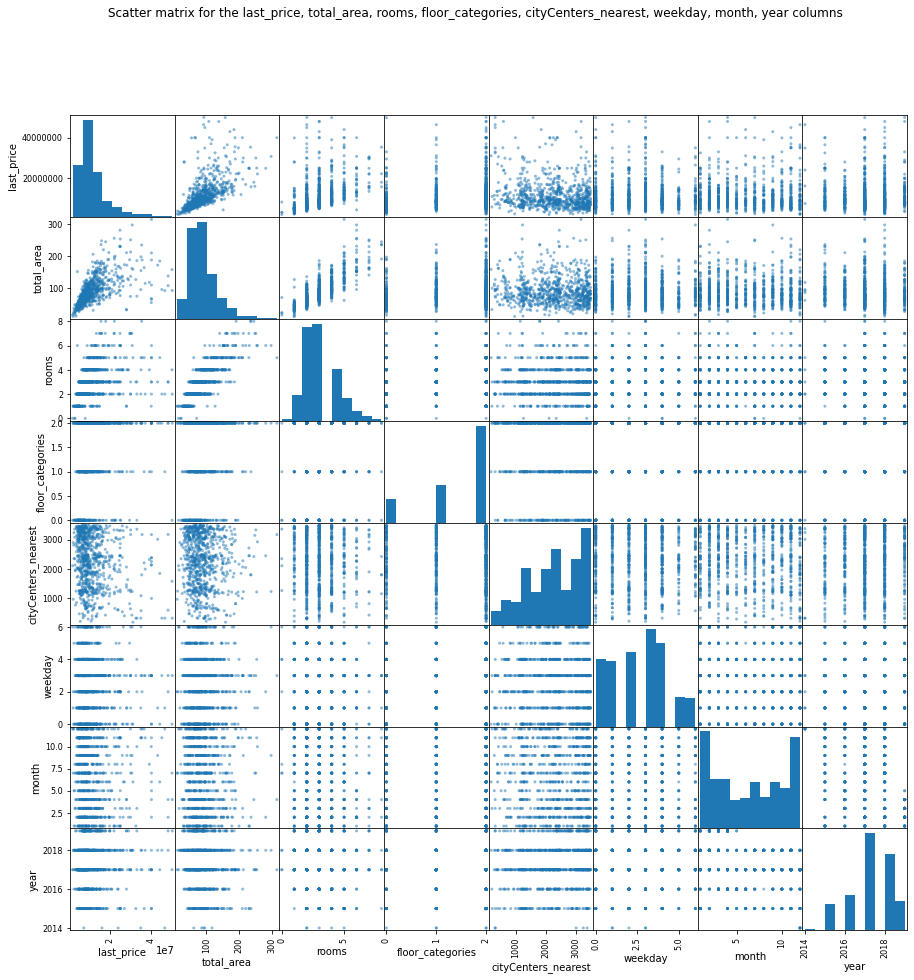

In [46]:
# Determine the dependence of the price of an apartment 
# in the center of St. Petersburg on the area,
# number of rooms, floors, distance to the city center, dates.
# Create a column slice for analysis.
spb_data_center_corrs = spb_data_center[['last_price',
                                         'total_area',
                                         'rooms',
                                         'floor_categories',
                                         'cityCenters_nearest',
                                         'weekday',
                                         'month',
                                         'year']]
pd.plotting.scatter_matrix(spb_data_center_corrs, figsize=(15,15))
plt.suptitle('Scatter matrix for the' +
             ' last_price, total_area, rooms, floor_categories,' + 
             ' cityCenters_nearest, weekday, month, year columns')
display(spb_data_center_corrs.corr())

<p><u><strong>Analysis of the influence of factors on the price of an apartment in the center of St. Petersburg</strong></u></p>
<br/> Analysis of the scatter matrix, as well as Pearson's correlation coefficients showed:
<br/><li>There is a direct correlation of the price of an apartment on its area, but not as strong as in the case of apartments on average in St. Petersburg.</li>
<br/><li>There is a direct relationship between the price of an apartment and the number of rooms. However, it is not very strong. Moreover, the correlation coefficient is 0.1 less than the average for St. Petersburg.</li>
<br/><li>There is an extremely small direct relationship between the price of an apartment and its floor. In the center of St. Petersburg, it is slightly higher than the average for the city.</li>
<br/><li>There is a weak inverse relationship between the price of an apartment and its distance to the center. Moreover, the correlation coefficient is 0.12 less than the average for St. Petersburg.</li>
<br/><li>There is almost no connection between the price of an apartment and the date the listing was posted (be it a day, a month, or a year).</li>

<p><u><strong>Conclusion:</strong></u></p> The determining factor in the formation of the price of an apartment located in the center of St. Petersburg is its area. The number of rooms can also affect pricing. The distance to the city center slightly affects the formation of prices. To a small extent, the price of an apartment can be affected by the floor on which it is located. There is practically no connection between the price of an apartment and the date the ad was placed (be it a day, a month or a year).
<br/>It is worth noting the differences in the influence of factors on the price of apartments in the center of St. Petersburg and the average price of apartments in St. Petersburg:
<br/><li>The dependence of the price of an apartment on its area (and on the number of rooms) in the city center is not as strong as in the case of apartments on average in St. Petersburg. This can be explained by the fact that the cultural value of the apartment, its layout, and the presence of antiquities "interfere" in the formation of the price of an apartment in the city center. It is worth noting that almost the entire center of St. Petersburg is historical and has a large area. And on average, the date of construction of buildings in the center is the 19th century (https://www.cian.ru/stati-10-otlichij-rynkov-zhilja-moskvy-i-sankt-peterburga-218316/). This, of course, is also taken into account when pricing.</li>
<br/><li>In the center of St. Petersburg, the relationship between the price of an apartment and the floor on which it is located is slightly higher than the city average. This can be explained by the fact that in the center of St. Petersburg there are a large number of pre-revolutionary buildings that are not equipped with an elevator due to the small number of storeys, but at the same time have high flights of stairs. Sellers and buyers take this factor into account a little more often than the average in the city (for example, in residential areas you will not surprise anyone with the presence of an elevator, and, as a result, the floor of the apartment plays a smaller role in pricing).</li>
<br/><li>The distance to the city center plays a slightly smaller role in determining the price of apartments located in the city center than the average for St. Petersburg. This is pretty logical and needs no explanation.</li>

## General Conclusion

This project work has shown how diverse the housing market is in St. Petersburg and its suburbs. So, for example, an apartment can be sold in 1 day, or maybe in 4 years. The difference in price, area, ceiling height can reach incredible values at first. Let us list the main conclusions of the study.
<p><u><strong>Main findings of the study</strong></u></p>
<strong>Saint Petersburg data:</strong>
<br/><li>The median price of an apartment is 4,600,000 rubles</li>
<br/><li>Among the 10 most mentioned listings for the sale of apartments, apartments in St. Petersburg are the most common. Least of all &ndash; in Vyborg. The same settlements rank first and tenth in terms of the average price per square meter of housing: 112,264 rubles/m<sup>2</sup> and 58,141 rubles/m<sup>2</sup>, respectively.</li>
<br/><li>It usually takes 95 days to sell an apartment.</li>
<br/><li>The determining factor in the formation of the price of an apartment to a greater extent is its area. Also, pricing can be affected by the number of rooms and the distance to the city center. To a small extent, the price of an apartment can be affected by the floor on which it is located. The date of placement of the ad does not affect the price of the apartment. </li>  
  
**Data for the center of St. Petersburg:**
<br/><li>The radius of the city center is estimated to be 4 km.</li>
<br/><li>The median price of an apartment is 9,400,000 rubles</li>
<br/><li>The price of a square meter of housing is 133,293 rubles</li>
<br/><li>It usually takes 134 days to sell an apartment.</li>
<br/><li>The determining factor in the formation of the price of an apartment is to a greater extent its area, but its influence on the price is less than for apartments in St. Petersburg as a whole. Presumably this is due to the characteristics of each particular apartment. Also, pricing can be affected by the number of rooms and the distance to the city center; these parameters also have less effect on the price, compared with the data for St. Petersburg as a whole. To a small extent, the price of an apartment can be affected by the floor on which it is located. At the same time, in the city center, the floor of an apartment affects the price more than in St. Petersburg as a whole. Perhaps this is due to the high flights of stairs and the relatively frequent absence of elevators in the houses of the central part of the city. The date of placement of the ad does not affect the price of the apartment. </li>